<a href="https://colab.research.google.com/github/andersonfedel/CNN-for-Cephalometric-Analysis/blob/master/COVID_WORLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests, zipfile, io
from scipy.signal import find_peaks
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# #Montagem do Drive Google 
# from google.colab import drive 
# drive.mount('/content/gdrive',force_remount=True)

##Repositório Our World in Data
https://github.com/owid/covid-19-data

In [3]:
#Definindo url com dados COVID WORLD 
url = "https://github.com/owid/covid-19-data/raw/master/public/data/owid-covid-data.csv"
data = pd.read_csv(url, parse_dates=["date"])

In [4]:
#Colunas disponíveis 
data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [5]:
#Configurando colunas a serem utilizadas:
cols = ['date','location', 'new_cases_per_million','hosp_patients', 
        'new_deaths_per_million', 'new_tests_per_thousand',
        'positive_rate', 'tests_per_case','total_vaccinations_per_hundred',
        'people_fully_vaccinated_per_hundred','population_density', 'gdp_per_capita',
        'human_development_index']



#Definindo dataset
df = data[cols]
df = df[df.date >= pd.to_datetime('2020-04-01')]
df = df.set_index(["location", "date"])
df.head()

new_cases_per_million  ...  human_development_index
location    date                               ...                         
Afghanistan 2020-04-01                  0.653  ...                    0.511
            2020-04-02                  1.079  ...                    0.511
            2020-04-03                  0.854  ...                    0.511
            2020-04-04                  0.025  ...                    0.511
            2020-04-05                  0.728  ...                    0.511

[5 rows x 11 columns]

In [6]:
#Confirmando que nao há registros duplicados para uma mesma data e um mesmo país
df.index.duplicated().sum()

0

In [7]:
#Definindo países a serem analisados:
#countries = ["South Africa", "United Kingdom", "Canada", "France"]
# #filtrando países selecionados
# df = df.loc[countries,:]

In [8]:
df.loc["Brazil", "gdp_per_capita"]

date
2020-04-01    14103.452
2020-04-02    14103.452
2020-04-03    14103.452
2020-04-04    14103.452
2020-04-05    14103.452
                ...    
2022-01-21    14103.452
2022-01-22    14103.452
2022-01-23    14103.452
2022-01-24    14103.452
2022-01-25    14103.452
Name: gdp_per_capita, Length: 665, dtype: float64

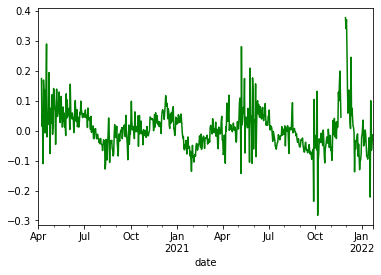

In [9]:
#Analisando a taxa de crescimento no número de casos em média móvel de 7 dias
def growth_rate(df, country, window):
  country_window = df.loc[country, "new_cases_per_million"].rolling(window).mean()
  country_window_index = df.loc[country, "new_cases_per_million"].index
  return pd.Series((np.exp(np.diff(np.log(country_window))) -1 ), index= country_window_index[0:-1])

# growth_rate(df, "United States", 7).plot()
# growth_rate(df, "United Kingdom", 7).plot(color="r")
growth_rate(df, "South Africa", 7).plot(color="g")

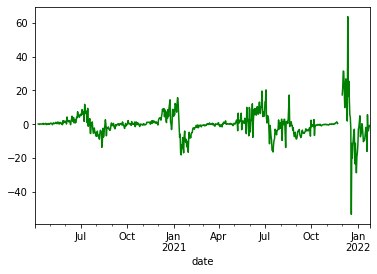

In [10]:
#Analisando a diferença diária no número de casos em média móvel de 7 dias
def lag1(df, country, window):
  country_window = df.loc[country, "new_cases_per_million"].rolling(window).mean()
  country_window_index = df.loc[country, "new_cases_per_million"].index
  return pd.Series(np.diff(country_window), index= country_window_index[1:])

# lag1(df, "United States", 7).plot()
# lag1(df, "United Kingdom", 7).plot(color="r")
lag1(df, "South Africa", 7).plot(color="g")

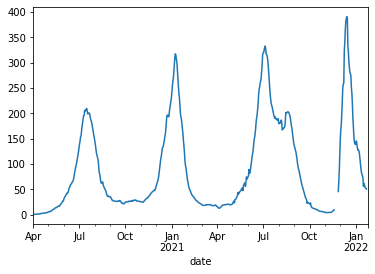

In [11]:
df.loc["South Africa", "new_cases_per_million"].rolling(7, center=True).mean().plot()

In [12]:
#Selecionando países a serem analisados
country1 = "South Africa"
country2 = "Brazil"

#Defininfo gráfico 1
time_series = df.loc[country1, "new_cases_per_million"].rolling(7, center=True).mean()

indices = find_peaks(time_series, prominence=100, width=10)[0]

#Definindo número de subplots
fig = make_subplots(rows=2, cols=1)
#fig = go.Figure()
fig.add_trace(go.Scatter(
    x = time_series.index,
    y=time_series,
    mode='lines+markers',
    name=f'{country1}'
),
    row=1, col=1)

fig.add_trace(go.Scatter(
    x=time_series[indices].index,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Potential Peaks'
),
    row=1, col=1)

fig.update_layout(
    title = f'COVID-19 World <b>{country1}</b> and <b>{country2}</b>' +'<br>' +'New cases per million moving average (7 days)', 
    
)

#Definindo gráfico2

time_series = df.loc[country2, "new_cases_per_million"].rolling(7, center=True).mean()

indices = find_peaks(time_series, prominence=100, width=10)[0]
fig.add_trace(go.Scatter(
    x = time_series.index,
    y=time_series,
    mode='lines+markers',
    name=f'{country2}'
),
    row=2, col=1)

fig.add_trace(go.Scatter(
    x=time_series[indices].index,
    y=[time_series[j] for j in indices],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Potential Peaks'
),
    row=2, col=1)



fig.show()

In [13]:
time_series = df.loc[country1, "new_cases_per_million"].rolling(7, center=True).mean()

indices = find_peaks(time_series, prominence=100, width=10)[0]

In [15]:
# countries = ["South Africa", "United Kingdom", "Canada", "United States"]
# countries2 = np.array(countries).reshape((numrows, numcols))
# countries2[0][0]

In [16]:
#Selecionando países a serem analisados
countries = ["South Africa", "United Kingdom", "Canada", "United States"]

#Definindo número de subplots
numcols = 2
numrows = len(countries)//numcols if not numcols%2 else len(countries)//numcols + 1
fig = make_subplots(rows=numrows, cols=numcols,
                    subplot_titles=([i for i in countries]),

                    #ATENÇÂO! Não está dentro da iteração. Ajustar manualmente!
                    specs= [[{"secondary_y":True},{"secondary_y":True}],[{"secondary_y":True},{"secondary_y":True}]])
   
countries2 = np.array(countries).reshape((numrows, numcols))

for i in range(1, numrows+1):
  for j in range(1, numcols+1):
    
    country_plot = countries2[i-1][j-1]

    if country_plot == countries[-1]:
      legend = True
    else:
      legend = False

    #Definindo série temporal do país
    time_series = df.loc[ country_plot , "new_cases_per_million"].rolling(7, center=True).mean()    
    #prováveis picos 
    peaks = find_peaks(time_series, prominence=100, width=10)[0]

#Eixo y primário
    fig.add_trace(go.Scatter(
    x = time_series.index,
    y=time_series,
    mode='lines+markers',
    marker=dict(size=3,
                color="lightgreen"),
    showlegend=legend,
    name=f'Cases per million'
      ),
    row=i, col=j,
    secondary_y=False)

    #fig.update_layout(showlegend=False)

    #Plot dos picos prováveis   
    fig.add_trace(go.Scatter(
        x=time_series[peaks].index,
        y=[time_series[j] for j in peaks],
        mode='markers',
        marker=dict(
            size=5,
            color='darkgrey',
            symbol='cross'
        ),
        showlegend=False,
        name='Potential Peaks'
      ),
        row=i, col=j,secondary_y=False )
        

#Eixo y secundário
    time_series2 = df.loc[ country_plot , 'hosp_patients'].rolling(7, center=True).mean()
    peaks2 = find_peaks(time_series2, prominence=100, width=10)[0] 

    fig.add_trace(go.Line(
    x = time_series2.index,
    y=time_series2,
    mode='lines+markers',
    marker=dict(
            size=3, 
            color="lightblue",
            ),
        showlegend=legend,
            
    name=f'Hospital patients'
      ),
    row=i, col=j,
    secondary_y=True)


    #Plot dos picos prováveis eixo secundário  
    fig.add_trace(go.Scatter(
        x=time_series2[peaks2].index,
        y=[time_series2[j] for j in peaks2],
        mode='markers',
        marker=dict(
            size=5,
            color='grey',
            symbol='cross'
        ),
        name='Potential Peaks2',
        showlegend=False,
      ),
        row=i, col=j,secondary_y=True )     
    

#Título superior
    fig.update_layout(
        title = {'text': f'COVID-19 World'  +'<br>' +'<b>New cases per million</b> and <b>hospital patients</b> moving averages (7 days)', 
                  'y':0.95,
                  'x':0.5,       
                  'xanchor': 'center',
                  'yanchor': 'top'})
    



fig.show()    

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [17]:
    #Plot dos picos prováveis   
    fig.add_trace(go.Scatter(
        x=time_series2[peaks2].index,
        y=[time_series2[j] for j in peaks2],
        mode='markers',
        marker=dict(
            size=5,
            color='green',
            symbol='cross'
        ),
        name='Potential Peaks2'
      ),
        row=i, col=j,secondary_y=True )    